## Bare pretrained Resnet backbone evaluation

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_dir = "../pretrained_backbone/ckpt_resnet18_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    for X, _ in tqdm(loader):
        output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
        preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:01<00:00,  6.75it/s]

              precision    recall  f1-score   support

           D       0.74      0.35      0.48       140
           G       0.51      0.53      0.52        49
           A       0.38      0.77      0.51        22

   micro avg       0.57      0.44      0.49       211
   macro avg       0.54      0.55      0.50       211
weighted avg       0.65      0.44      0.49       211
 samples avg       0.59      0.42      0.37       211



### Offsite

![](resnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "resnet_submission_notune.csv")

100%|██████████| 8/8 [00:01<00:00,  7.80it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.fc.parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

Using Adam with default parameters, no weight decay + a bit of LR scheduling

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch: 0 - Train Loss: 1.164056 - Val Loss: 0.771976 - Val Accuracy: 0.334821 - Val F1 (avg. samples): 0.465774
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]


Epoch: 1 - Train Loss: 0.600479 - Val Loss: 0.598302 - Val Accuracy: 0.495536 - Val F1 (avg. samples): 0.572917
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


Epoch: 2 - Train Loss: 0.490192 - Val Loss: 0.529974 - Val Accuracy: 0.504464 - Val F1 (avg. samples): 0.561012
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]


Epoch: 3 - Train Loss: 0.478970 - Val Loss: 0.524241 - Val Accuracy: 0.486607 - Val F1 (avg. samples): 0.561012
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


Epoch: 4 - Train Loss: 0.466353 - Val Loss: 0.506494 - Val Accuracy: 0.504464 - Val F1 (avg. samples): 0.563988
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch: 5 - Train Loss: 0.467499 - Val Loss: 0.506875 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.574405


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


Epoch: 6 - Train Loss: 0.457662 - Val Loss: 0.530458 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.604167


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


Epoch: 7 - Train Loss: 0.456678 - Val Loss: 0.525919 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.571429


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch: 8 - Train Loss: 0.449611 - Val Loss: 0.514553 - Val Accuracy: 0.517857 - Val F1 (avg. samples): 0.592262


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch: 9 - Train Loss: 0.441201 - Val Loss: 0.491068 - Val Accuracy: 0.504464 - Val F1 (avg. samples): 0.581845
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s]


Epoch: 10 - Train Loss: 0.447979 - Val Loss: 0.487912 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.583333
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch: 11 - Train Loss: 0.443992 - Val Loss: 0.505610 - Val Accuracy: 0.495536 - Val F1 (avg. samples): 0.572917


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


Epoch: 12 - Train Loss: 0.438077 - Val Loss: 0.493477 - Val Accuracy: 0.491071 - Val F1 (avg. samples): 0.577381


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch: 13 - Train Loss: 0.437250 - Val Loss: 0.514578 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.596726


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.64it/s]


Epoch: 14 - Train Loss: 0.440369 - Val Loss: 0.496813 - Val Accuracy: 0.535714 - Val F1 (avg. samples): 0.627976


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


Epoch: 15 - Train Loss: 0.433842 - Val Loss: 0.488248 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.620536


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.10it/s]


Epoch: 16 - Train Loss: 0.427183 - Val Loss: 0.494493 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.627976


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch: 17 - Train Loss: 0.429441 - Val Loss: 0.488412 - Val Accuracy: 0.535714 - Val F1 (avg. samples): 0.627976


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


Epoch: 18 - Train Loss: 0.427368 - Val Loss: 0.480007 - Val Accuracy: 0.540179 - Val F1 (avg. samples): 0.620536
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch: 19 - Train Loss: 0.429695 - Val Loss: 0.493360 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.619048


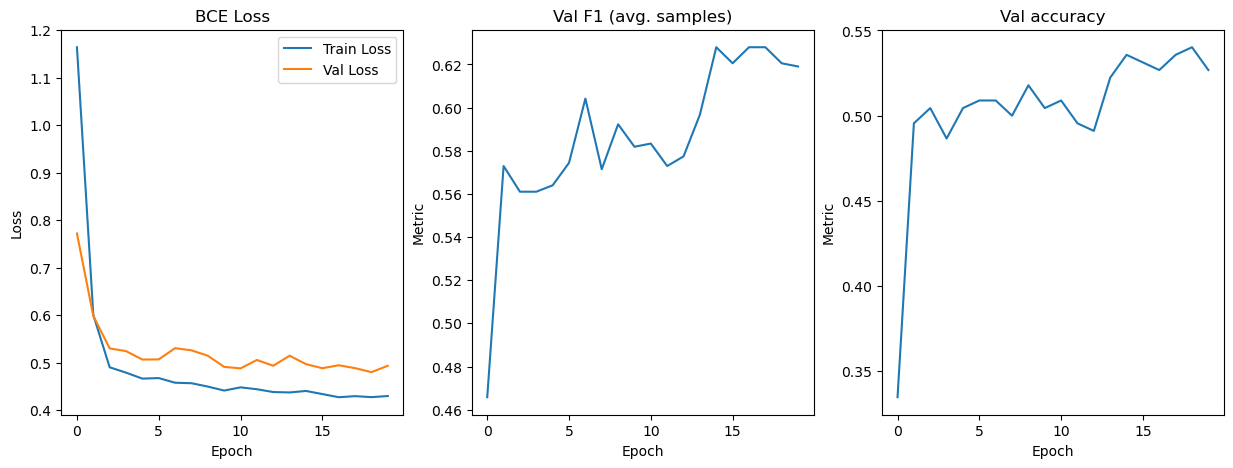

In [12]:
optimizer = torch.optim.Adam(model.model.fc.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="resnet_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  9.16it/s]

              precision    recall  f1-score   support

           D       0.80      0.92      0.85       140
           G       0.81      0.27      0.40        49
           A       0.75      0.41      0.53        22

   micro avg       0.79      0.72      0.75       211
   macro avg       0.79      0.53      0.59       211
weighted avg       0.80      0.72      0.71       211
 samples avg       0.80      0.73      0.73       211



### Onsite test
![](resnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "resnet_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


## Full fine-tuning

We previously tuned the classifer, and we further now tune everything, using the best model from previous stage

Using AdamW with default weight decay of 0.01, LR reduced 3 times after epoch 15, practically there is no need to train for 30 epochs, maximum 15-20 epochs, overfits.

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


Epoch: 0 - Train Loss: 0.416594 - Val Loss: 0.450375 - Val Accuracy: 0.584821 - Val F1 (avg. samples): 0.674107
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.42it/s]


Epoch: 1 - Train Loss: 0.376493 - Val Loss: 0.421938 - Val Accuracy: 0.593750 - Val F1 (avg. samples): 0.683036
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.74it/s]


Epoch: 2 - Train Loss: 0.338532 - Val Loss: 0.409772 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.690476
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s]


Epoch: 3 - Train Loss: 0.312328 - Val Loss: 0.394691 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.724702
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


Epoch: 4 - Train Loss: 0.284782 - Val Loss: 0.392063 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.726190
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s]


Epoch: 5 - Train Loss: 0.270039 - Val Loss: 0.386247 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.735119
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


Epoch: 6 - Train Loss: 0.246630 - Val Loss: 0.381948 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.732143
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]


Epoch: 7 - Train Loss: 0.227701 - Val Loss: 0.383105 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.37it/s]


Epoch: 8 - Train Loss: 0.208350 - Val Loss: 0.380197 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.755952
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


Epoch: 9 - Train Loss: 0.186520 - Val Loss: 0.380725 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.758929


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.44it/s]


Epoch: 10 - Train Loss: 0.174576 - Val Loss: 0.382980 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


Epoch: 11 - Train Loss: 0.157673 - Val Loss: 0.390297 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.750000


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.13it/s]


Epoch: 12 - Train Loss: 0.138532 - Val Loss: 0.390499 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.750000


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


Epoch: 13 - Train Loss: 0.116454 - Val Loss: 0.389447 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 14 - Train Loss: 0.114384 - Val Loss: 0.386351 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.747024


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


Epoch: 15 - Train Loss: 0.098004 - Val Loss: 0.395001 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.752976


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


Epoch: 16 - Train Loss: 0.091542 - Val Loss: 0.398018 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


Epoch: 17 - Train Loss: 0.099996 - Val Loss: 0.396854 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch: 18 - Train Loss: 0.091442 - Val Loss: 0.396093 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.754464


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


Epoch: 19 - Train Loss: 0.083638 - Val Loss: 0.392014 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.82it/s]


Epoch: 20 - Train Loss: 0.084020 - Val Loss: 0.399006 - Val Accuracy: 0.647321 - Val F1 (avg. samples): 0.760417


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


Epoch: 21 - Train Loss: 0.085703 - Val Loss: 0.406047 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.747024


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


Epoch: 22 - Train Loss: 0.078311 - Val Loss: 0.398793 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.754464


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


Epoch: 23 - Train Loss: 0.073952 - Val Loss: 0.401392 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.745536


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch: 24 - Train Loss: 0.071196 - Val Loss: 0.405532 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.744048


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


Epoch: 25 - Train Loss: 0.072834 - Val Loss: 0.397486 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.758929


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch: 26 - Train Loss: 0.067257 - Val Loss: 0.411435 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.744048


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]


Epoch: 27 - Train Loss: 0.065910 - Val Loss: 0.404392 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.750000


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


Epoch: 28 - Train Loss: 0.062030 - Val Loss: 0.401372 - Val Accuracy: 0.647321 - Val F1 (avg. samples): 0.769345


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


Epoch: 29 - Train Loss: 0.059998 - Val Loss: 0.409174 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.739583


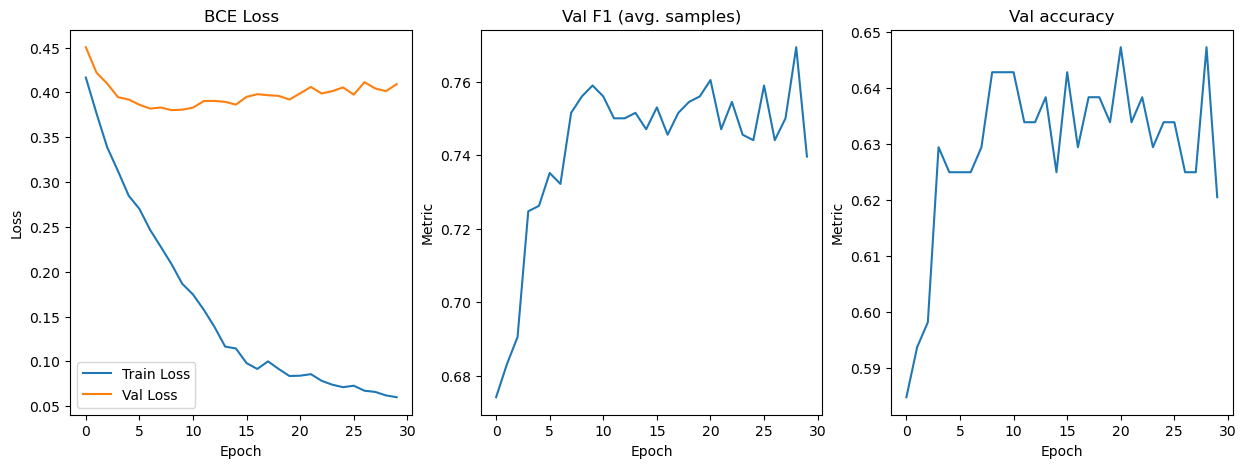

In [ ]:
'''
backbone_params = []
fc_params = []
for name, param in model.named_parameters():
    if "fc" not in name:
        backbone_params.append(param)
    else:
        fc_params.append(param)
'''
for layer in model.parameters():
    layer.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) #default weight decay 0.01
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15, gamma=0.3)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=30, stepLR = scheduler, checkpoint_name="resnet.pt")

### Offsite

In [17]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


              precision    recall  f1-score   support

           D       0.85      0.92      0.88       140
           G       0.88      0.61      0.72        49
           A       0.65      0.59      0.62        22

   micro avg       0.83      0.82      0.82       211
   macro avg       0.79      0.71      0.74       211
weighted avg       0.84      0.82      0.82       211
 samples avg       0.85      0.83      0.82       211



### Onsite test
![](resnet_classifier_full.png)

In [18]:
eval_model(model, onsite_test, "resnet_submission_full.csv")

100%|██████████| 8/8 [00:00<00:00,  8.64it/s]
